In [ ]:
using OffsetArrays, Parameters, Plots, ForwardDiff, NLsolve
using ForwardDiff: jacobian, derivative
using Perla1

In [2]:
gr(fmt = :png);

# Model specification

In [3]:
params = params_demand_default_symmetric()

(Ω = 1.0, σ = 0.15, κ = 3.5, mc = 1.0, Γ_bar = 0.865600495724366, N = 4, N_ks = (4,), cohorts = (4, 4), q = 2.0:1.0:3.0)

In [4]:
N = params.cohorts[1]
b_bar = length(params.cohorts);
f = fill(1/(N+1)^b_bar, (N+1)^b_bar); # awareness set distribution

# Demand function with multiple cohorts

In [5]:
# Demand function with multiple cohorts
# p_i: the price of product of firm i (can be different from p[b])
# b: the cohort firm i belongs to
# p: b_bar-vector of prices across firms
# f: awareness set distribution
# params: model parameters
demand(p_i, b, p, f, params) = demand_symmetric(p_i, b, p, f, params)
profit(p_i, b, p, f, params) = (p_i - params.mc) * demand(p_i, b, p, f, params)
profit_derivative(p_i, b, p, f, params) = derivative(p_i -> profit(p_i, b, p, f, params), p_i)

profit_derivative (generic function with 1 method)

In [6]:
b = 1 # the cohort firm i belongs to
p = fill(1.0, b_bar); # b_bar-vector of prices

## Plots

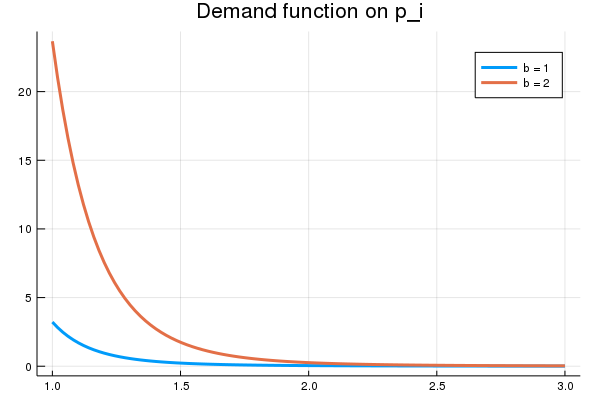

In [7]:
# plot the demand function
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> demand(p_i, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:b_bar), lw = 3, title = "Demand function on p_i")

In [8]:
# confirm that the demand function is decreasing in price
@assert all(diff((p_i -> demand(p_i, b, p, f, params)).(1:100)) .< 0)

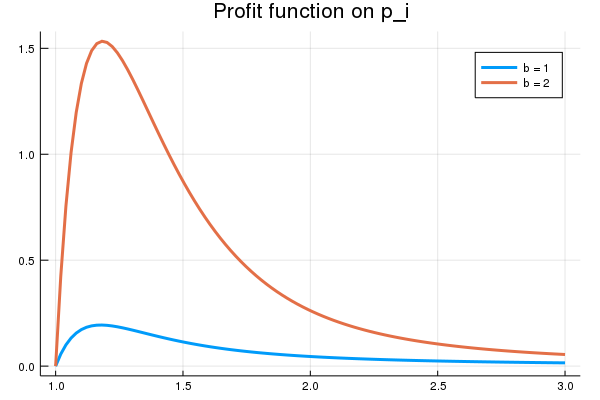

In [9]:
# plot the profit function
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> profit(p_i, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:b_bar), lw = 3, title = "Profit function on p_i")

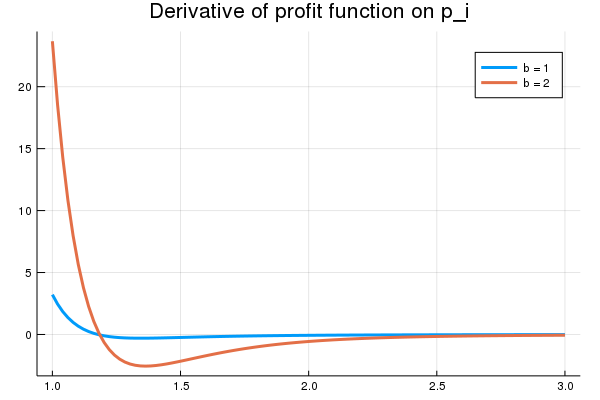

In [10]:
# plot the profit derivative function
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> profit_derivative(p_i, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:b_bar), lw = 3, title = "Derivative of profit function on p_i")

# Solve Nash equilibria

In [11]:
function D_p(p, f, params)
    # K-vector of cohorts where ith element represents ith firms' cohort
    bs = 1:length(params.cohorts)
    # return the vector of derivatives
    return [profit_derivative(p[b], bs[b], p, f, params) for b in eachindex(p)]
end

function nash_equilibrium(f, params; autodiff=:forward, iv = fill(params.mc, length(params.cohorts)))
    sol = nlsolve(p -> D_p(p, f, params), iv, autodiff = :forward)
    return (p = sol.zero, converged = converged(sol), solution = sol)
end

nash_equilibrium (generic function with 1 method)

In [12]:
p = nash_equilibrium(f, params).p

2-element Array{Float64,1}:
 1.180366159969776 
 1.2045730328895206

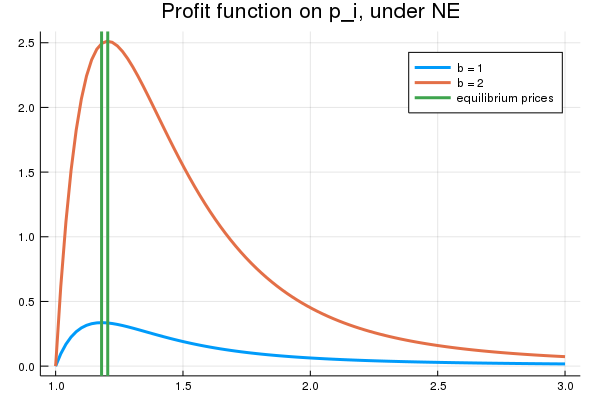

In [13]:
# plot the profit function
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> profit(p_i, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:b_bar), lw = 3, title = "Profit function on p_i, under NE")
plot!(p, st = :vline, lw = 3, label = "equilibrium prices")